# News Recommendation System


The News Article Recommendation System is a project designed to provide personalized article recommendations based on the content of news headlines. The system utilizes natural language processing (NLP) techniques and machine learning algorithms to analyze and understand the similarities between news articles, enabling it to suggest relevant articles to users based on their interests.
The goal of this project is to enhance the user experience by offering curated article recommendations that align with their preferences and reading habits. By leveraging the power of NLP, the system identifies the underlying semantic meaning of news headlines and establishes connections between different articles, thereby providing users with a tailored selection of articles that match their interests.

## Importing necessary Libraries


In [25]:
import numpy as np
import pandas as pd

import os
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import pairwise_distances

## Loading Data

In [2]:
raw_df = pd.read_json("News_Category_Dataset_v2.json", lines = True)

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [4]:
raw_df.describe()

C:\Users\Ojasvi Doye\AppData\Local\Temp\ipykernel_8228\2990293585.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  raw_df.describe()


,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://stylelike...,,2013-04-24 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


In [5]:
raw_df.columns.unique()

Index(['category', 'headline', 'authors', 'link', 'short_description', 'date'], dtype='object')

In [6]:
raw_df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [7]:
raw_df.tail()

,category,headline,authors,link,short_description,date
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28
200852,SPORTS,Dwight Howard Rips Teammates After Magic Loss ...,,https://www.huffingtonpost.com/entry/dwight-ho...,The five-time all-star center tore into his te...,2012-01-28


## Data Preprocessing

#### Fetching only the articles from 2018

Since the dataset size is quite large so processing through entire dataset may consume too much time.

In [9]:
start_date = pd.Timestamp(2016, 1, 1)
raw_df = raw_df[raw_df['date'] >= start_date]

In [10]:
raw_df.shape

(70570, 6)

In [13]:
# Sort the DataFrame by headline in descending order
raw_df.sort_values('headline', inplace=True, ascending=False)

# Find duplicate articles based on the 'headline' column
duplicate_raw_df = raw_df.duplicated('headline', keep=False)

# Remove duplicate articles from the DataFrame
raw_df = raw_df[~duplicate_raw_df]

# Print the total number of articles after removing duplicates
print(raw_df.shape)

(70317, 6)


#### Checking for null values

In [14]:
raw_df.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

In [15]:
raw_df.reset_index(inplace = True)
raw_df

,index,category,headline,authors,link,short_description,date
0,36290,WOMEN,"“We Shall Overcomb!” Say The 100,000 Marching ...","Darin Graham, ContributorJournalist",https://www.huffingtonpost.com/entry/we-shall-...,Thousands of activists descended on London to ...,2017-01-25
1,21194,HEALTHY LIVING,“To The Bone” Didn’t Teach Me Glamour. It Taug...,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,"Oftentimes, films or TV shows about eating dis...",2017-07-18
2,29672,BUSINESS,"“I’m Sorry""--The Two Tragically Forgotten Word...","Dana Brownlee, ContributorPresident of Profess...",https://www.huffingtonpost.com/entry/im-sorryt...,"Unfortunately, I was one of those frustrated p...",2017-04-10
3,2932,QUEER VOICES,‘Will & Grace’ Creator To Donate Gay Bunny Boo...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,It's about to be a lot easier for kids in Mike...,2018-04-02
4,67601,WEIRD NEWS,‘Wild Boar Curling’ Rescues Stranded Wild Boar...,Nina Golgowski,https://www.huffingtonpost.com/entry/wild-boar...,Get this pig in a blanket!,2016-02-03
...,...,...,...,...,...,...,...
70312,60589,ENTERTAINMENT,"""Bosch"" Is Back and Better Than Ever","Jackie K. Cooper, ContributorFilm Critic",https://www.huffingtonpost.com/entry/bosch-is-...,,2016-04-24
70313,68627,POLITICS,"""Black Lives Matter"" (the ""Too"" Is Silent)","Rick Horowitz, ContributorMilwaukee Public TV ...",https://www.huffingtonpost.com/entry/black-liv...,It's pretty easy to understand. Unless you're ...,2016-01-23
70314,50799,ENTERTAINMENT,"""Bachelors"" Is a Profanity Laden RomCom","Jackie K. Cooper, ContributorFilm Critic",https://www.huffingtonpost.com/entry/bachelors...,,2016-08-13
70315,40225,ENTERTAINMENT,"""An International Film Festival with an Arab H...","E. Nina Rothe, ContributorCultural Activist",https://www.huffingtonpost.com/entry/an-intern...,,2016-12-11


#### Removing all the short headline articles

In [16]:
counts = raw_df.category.value_counts()

In [17]:
raw_df = raw_df[raw_df['headline'].str.split().apply(len) > 5]
total_articles = len(raw_df)
print("Total number of articles after removing headlines with fewer than 5 words:", total_articles)

Total number of articles after removing headlines with fewer than 5 words: 67952


In [18]:
raw_df['category']

0                 WOMEN
1        HEALTHY LIVING
2              BUSINESS
3          QUEER VOICES
4            WEIRD NEWS
              ...      
70312     ENTERTAINMENT
70313          POLITICS
70314     ENTERTAINMENT
70315     ENTERTAINMENT
70316              ARTS
Name: category, Length: 67952, dtype: object

## Data Visualization

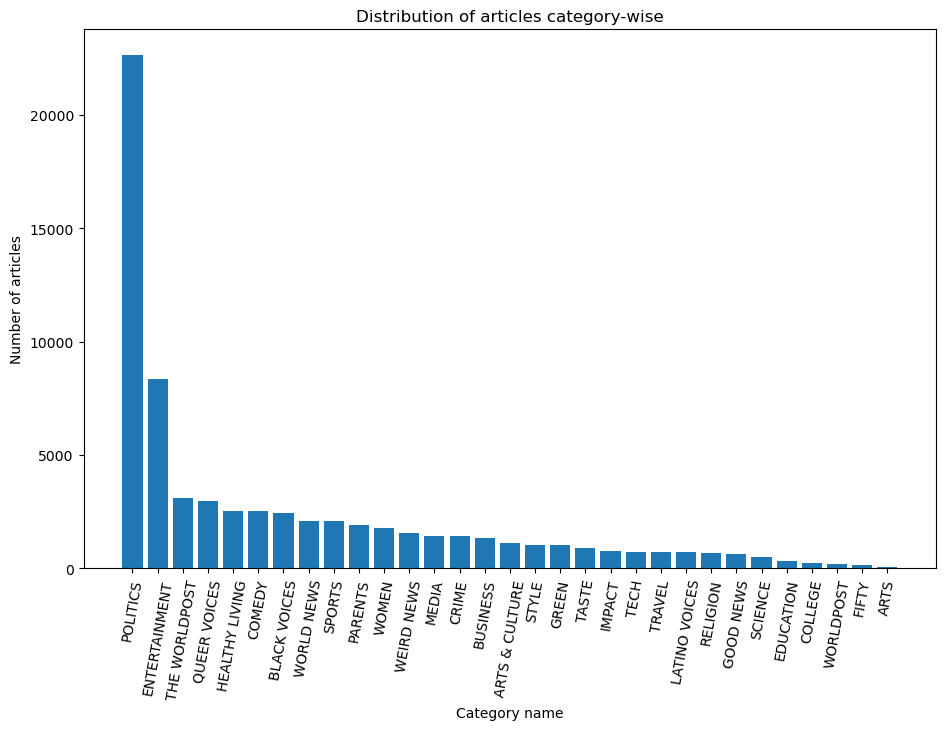

In [19]:
category_counts = raw_df["category"].value_counts()

plt.figure(figsize=(11, 7))
plt.bar(category_counts.index, category_counts.values)
plt.title("Distribution of articles category-wise")
plt.xlabel("Category name")
plt.ylabel("Number of articles")
plt.xticks(rotation=80)
plt.show()

In [20]:
news_articles_per_month = raw_df['date'].dt.month.value_counts().sort_index()
news_articles_per_month


1     7443
2     6666
3     6965
4     6520
5     6526
6     5059
7     4936
8     5096
9     4678
10    4931
11    4664
12    4468
Name: date, dtype: int64

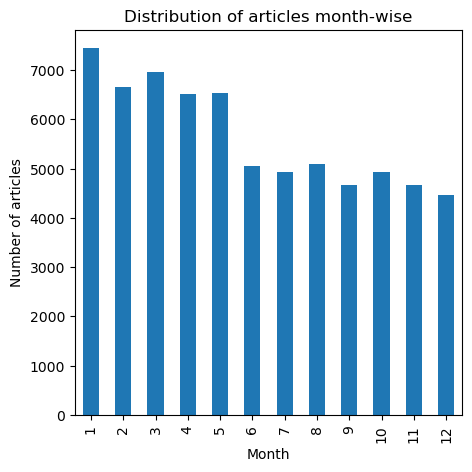

In [21]:
news_articles_per_month.plot(kind='bar', figsize=(5, 5))
plt.title("Distribution of articles month-wise")
plt.xlabel("Month")
plt.ylabel("Number of articles")
plt.show()

In [22]:
raw_df_temp = raw_df.copy()

In [23]:
# Set of stopwords in English
stop_words = set(stopwords.words('english'))

# Loop through each headline in the DataFrame
for i, headline in enumerate(raw_df_temp["headline"]):
    processed_words = []
    
    # Split the headline into individual words
    for word in headline.split():
        # Remove punctuation and convert to lowercase
        word = ''.join(e for e in word if e.isalnum())
        word = word.lower()
        
        # Check if word is not a stopword
        if word not in stop_words:
            processed_words.append(word)
    
    # Join the processed words and assign back to the DataFrame
    raw_df_temp.at[i, "headline"] = ' '.join(processed_words)
    
    # Print progress every 1000 iterations
    if i % 1000 == 0:
        print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000


#### Lemmatization

In [26]:
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

for i in range(len(raw_df_temp["headline"])):
    if i in raw_df_temp.index:
        string = ""
        for w in word_tokenize(raw_df_temp["headline"][i]):
            string += lemmatizer.lemmatize(w, pos="v") + " "
        raw_df_temp.at[i, "headline"] = string.strip()
    if i % 1000 == 0:
        print(i)


[nltk_data] Downloading package wordnet to C:\Users\Ojasvi
[nltk_data]     Doye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ojasvi
[nltk_data]     Doye\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000


## TF-IDF method

In [28]:
!pip install scikit-learn

tfidf_headline_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(raw_df_temp['headline'])

Defaulting to user installation because normal site-packages is not writeable


In [29]:
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features, tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[1:num_similar_items+1]
    
    recommended_articles = raw_df.iloc[indices][["date", "headline"]]
    queried_article_headline = raw_df["headline"].iloc[indices[0]]
    
    print("="*30, "Queried article details", "="*30)
    print('headline:', queried_article_headline)
    print("\n", "="*25, "Recommended articles", "="*23)
    
    return recommended_articles

tfidf_based_model(133, 11)

============================== Queried article details ==============================
headline: ‘Brooklyn Nine-Nine’ Finds New TV Home, Stars And Fans Rejoice

 ========================= Recommended articles =======================


,date,headline
134,2018-05-12,"‘Brooklyn Nine-Nine’ Finds New TV Home, Stars ..."
12796,2017-01-13,These Science-Backed Tips Will Help You Demoli...
28397,2016-06-29,Obama: Donald Trump A Populist? LOL.
9784,2018-02-02,"Trump Accuses His Justice Department, FBI Of F..."
52051,2016-08-30,Donald Trump’s Lack Of Support Among Black Vot...
6609,2018-02-09,U.S. Bobsled Team Pays Tribute To Late Gold Me...
9778,2017-04-17,"Trump Adding Former Lobbyists To Swamp, Giving..."
6770,2016-02-12,Two Latinas At Forefront Of Historic Science D...
4583,2016-06-14,Watch These Dogs React To A Human Who Barks As...
42416,2016-01-18,How To Start Your Day Off Right In 90 Simple S...
